## 1. Setup and Imports

In [5]:
!pip install azureml-core scikit-learn pandas numpy joblib matplotlib seaborn requests

In [12]:
!pip list | grep seaborn

seaborn                                    0.13.2


In [15]:
!python -m ipykernel install --user --name azureml_py38 --display-name "azureml_py38"

Installed kernelspec azureml_py38 in /home/azureuser/.local/share/jupyter/kernels/azureml_py38


In [16]:
!pip install seaborn

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from azureml.core import Workspace, Dataset, Model
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.environment import Environment
import requests
import json

# Verify environment and Connect to Azure ML Workspace

In [27]:
import sys
print(f"Python executable: {sys.executable}")  # Should show /anaconda/envs/azureml_py310_sdkv2/bin/python

# Connect to Azure ML Workspace
ws = Workspace.from_config()
print(f"Connected to workspace: {ws.name}")

Python executable: /anaconda/envs/azureml_py310_sdkv2/bin/python
Connected to workspace: azurelabsbyme09


### 2.1 Load Dataset

In [29]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
data = pd.read_csv(dataset_url, names=columns, skipinitialspace=True)

# Upload to Azure Blob Storage

In [30]:
data.to_csv('adult_income.csv', index=False)
datastore = ws.get_default_datastore()
datastore.upload_files(['adult_income.csv'], target_path='data/', overwrite=True)

Uploading an estimated of 1 files
Uploading adult_income.csv
Uploaded adult_income.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_8cc814abb4cb4514a2f4bed64a668281

# Register dataset in AML workspace

In [35]:
# Check for existing dataset and ensure it's a TabularDataset
try:
    dataset = Dataset.get_by_name(workspace=ws, name='adult_income')
    print("Found existing dataset 'adult_income'")
    # Check if it's a TabularDataset
    if isinstance(dataset, Dataset.Tabular):
        print("Dataset is already a TabularDataset")
    else:
        print("Existing dataset is not a TabularDataset, re-registering as TabularDataset")
        dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'data/adult_income.csv'))
        dataset = dataset.register(workspace=ws, name='adult_income', description='Adult Income Dataset', create_new_version=True)
except:
    # Register new dataset if not found
    print("Registering new 'adult_income' dataset as TabularDataset")
    dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'data/adult_income.csv'))
    dataset = dataset.register(workspace=ws, name='adult_income', description='Adult Income Dataset', create_new_version=True)

Found existing dataset 'adult_income'
Existing dataset is not a TabularDataset, re-registering as TabularDataset


# Load dataset into pandas


In [36]:
df = dataset.to_pandas_dataframe()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


### 2.2 Data Cleaning and Preprocessing

In [38]:
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# Define features and target
X = df.drop('income', axis=1)
y = df['income'].map({'<=50K': 0, '>50K': 1})

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Model Training

In [39]:
### 3.1 Model Selection
# Using Random Forest for classification
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

### 3.2 Train Model
model.fit(X_train, y_train)

### 3.3 Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation accuracy: 0.8508 (+/- 0.0046)


## 4. Model Evaluation

Validation Metrics:
Accuracy: 0.8508
Precision: 0.7354
Recall: 0.6431
F1 Score: 0.6862
ROC-AUC: 0.9038


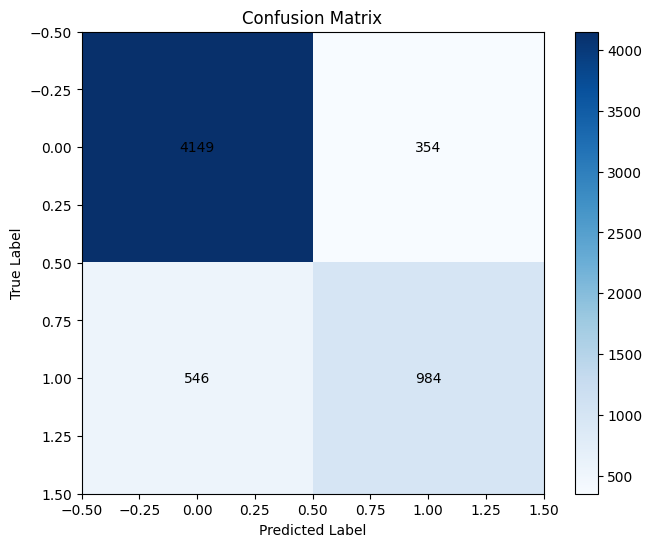

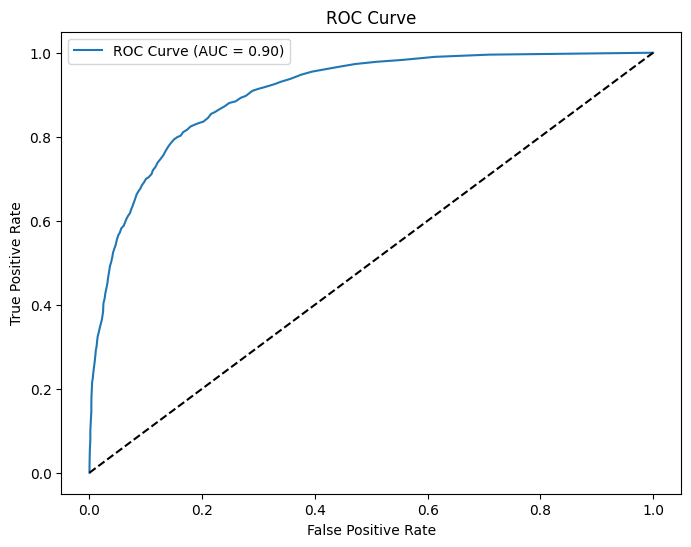

In [40]:
### 4.1 Calculate Metrics
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

print(f"Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

### 4.2 Visualizations
# Confusion Matrix (using matplotlib)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='black')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 5. Model Deployment

In [44]:
model_path = 'adult_income_model.pkl'
import joblib
joblib.dump(model, model_path)
registered_model = Model.register(workspace=ws, model_path=model_path, model_name='adult_income_model')

### 5.2 Create Scoring Script
# Write score.py using standard file operations instead of %%writefile
score_script_content = """
import joblib
import json
import numpy as np
import pandas as pd
from azureml.core.model import Model

def init():
    global model
    model_path = Model.get_model_path('adult_income_model')
    model = joblib.load(model_path)

def run(raw_data):
    try:
        data = pd.DataFrame(json.loads(raw_data))
        predictions = model.predict(data)
        probabilities = model.predict_proba(data)[:, 1]
        return json.dumps({
            'predictions': predictions.tolist(),
            'probabilities': probabilities.tolist()
        })
    except Exception as e:
        return json.dumps({"error": str(e)})
"""
with open('score.py', 'w') as f:
    f.write(score_script_content)


### 5.4 Deploy Model
inference_config = InferenceConfig(entry_script='score.py')
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)
service = Model.deploy(
    workspace=ws,
    name='adult-income-service',
    models=[registered_model],
    inference_config=inference_config,
    deployment_config=deployment_config
)
service.wait_for_deployment(show_output=True)
print(f"Service state: {service.state}")
print(f"Scoring URI: {service.scoring_uri}")

### 5.5 Test Deployment
# Sample input data
sample_input = X_val.iloc[:2].to_dict(orient='records')
sample_input_json = json.dumps(sample_input)

# Send request
headers = {'Content-Type': 'application/json'}
response = requests.post(service.scoring_uri, data=sample_input_json, headers=headers)
print(f"Prediction response: {response.json()}")

Registering model adult_income_model
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-09-22 05:07:21+00:00 Creating Container Registry if not exists.
Failed


/tmp/ipykernel_2999/3086898538.py:39: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(
Service deployment polling reached non-successful terminal state, current service state: Transitioning
Operation ID: 9bf5b4a2-08ef-4b99-899d-90a64aefcbe4
Current sub-operation type not known, more logs unavailable.
Error:
{
  "code": "AciDeploymentFailed",
  "statusCode": 400,
  "message": "Environment definition is not specified",
  "details": []
}



WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Transitioning
Operation ID: 9bf5b4a2-08ef-4b99-899d-90a64aefcbe4
Current sub-operation type not known, more logs unavailable.
Error:
{
  "code": "AciDeploymentFailed",
  "statusCode": 400,
  "message": "Environment definition is not specified",
  "details": []
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Transitioning\nOperation ID: 9bf5b4a2-08ef-4b99-899d-90a64aefcbe4\nCurrent sub-operation type not known, more logs unavailable.\nError:\n{\n  \"code\": \"AciDeploymentFailed\",\n  \"statusCode\": 400,\n  \"message\": \"Environment definition is not specified\",\n  \"details\": []\n}"
    }
}